# What

This notebook will be where the work for #165 will take place.

As per the issues there are three steps, getting embedding dataset, creating the vector database and then building the RAg on top.

## Modules

In [3]:
# engine
from engine.OpenAICaller import openAICaller

# Third Party
import pandas as pd
import numpy as np

from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv('../../.env')

import openai

from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
import lancedb
import pyarrow as pa

import voyageai

import yaml

# built in
import os
from typing import Callable

# Getting embeddings ready


In [4]:
def read_embedding(file_name):

    embedding_folder = 'embeddings'

    return pd.read_pickle(os.path.join(embedding_folder, file_name))

## Safety issues

In [5]:
safety_issue_embeddings = read_embedding('voyageai_si_embeddings.pkl')
safety_issue_embeddings.rename(columns={'si_embedding': 'vector'}, inplace=True)
display(safety_issue_embeddings)
print(f"Number of unique reports: {len(set(safety_issue_embeddings['report_id']))}")

,report_id,si,vector,year
0,2000_004,The aircraft checklist did not document the st...,"[0.006388493813574314, 0.030199440196156502, -...",2000
1,2000_004,The aircraft undercarriage unsafe warning syst...,"[-0.009670267812907696, 0.04131568968296051, -...",2000
2,2000_004,"The lack of additional systems, such as ground...","[0.004730127286165953, 0.006449047941714525, -...",2000
3,2000_004,The omission of the undercarriage checklist it...,"[0.03662460297346115, 0.011077090166509151, -0...",2000
4,2000_004,The pilot's apprehension about operating into ...,"[0.0701548233628273, -0.0018038754351437092, 0...",2000
...,...,...,...,...
1862,2023_101,KiwiRail had not identified HRV cabs as being ...,"[0.007095584645867348, 0.012432749383151531, -...",2023
1863,2023_101,The Ganger did not have adequate support to co...,"[0.007098471280187368, -0.008563312701880932, ...",2023
1864,2023_101,Training of staff covered operating a HRV with...,"[0.020521841943264008, -0.00937708094716072, -...",2023
1865,2023_103,Short staffing resulted in a track worker unde...,"[0.015345062129199505, -0.0005029932945035398,...",2023


Number of unique reports: 356


### Checking safety issues distrubitions

I have done a rerun of the safety issues and included all since 2000. This means I have alot more safety issues. I need to do a recheck to see if the safety issue extraction is good enough. I think it is quite variable as there seems to be 660ish where the last run through only had 560. More so I didn't think I was doing a run through where it would redo the safety issues.

<Axes: >

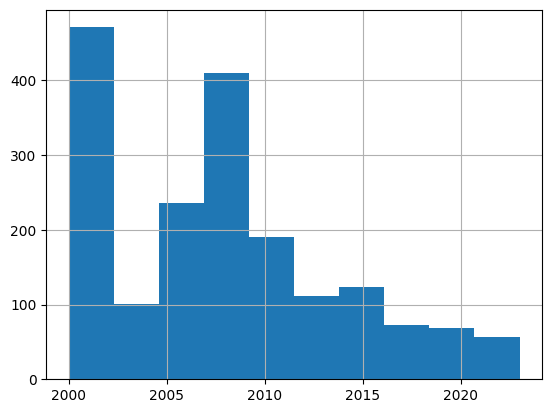

In [6]:
safety_issue_embeddings['year'] = safety_issue_embeddings['report_id'].apply(lambda x: int(x[0:4]))

safety_issue_embeddings['year'].hist()


## Important text

In [7]:
important_text_embeddings = read_embedding('voyageai_important_text_embeddings.pkl')

important_text_embeddings

,report_id,important_text,important_text_embedding,important_text_token_length
0,2001_010,<< Page 4 >>\n 1.5 Other information \n \n1.5...,"[0.006053609773516655, -0.0016210350440815091,...",1413
1,2019_106,<< Page 6 >>\n Final Report RO -2019 -106 3 An...,"[-0.011737811379134655, 0.014775536023080349, ...",4217
2,2013_107,<< Page 9 >>\n 4. Analysis \n4.1. Introductio...,"[-0.001134335296228528, -0.007460028864443302,...",5789
3,2020_102,<< Page 8 >>\n \n 3 Analysis \nIntroduction ...,"[-0.01555608119815588, 0.0022236795630306005, ...",4134
4,2011_003,<< Page 14 >>\n Final Report 11 -003 4. Analys...,"[-0.01336225587874651, 0.0007614989299327135, ...",15618
...,...,...,...,...
349,2020_104,<< Page 7 >>\n 3 Analysis \nIntroduction \n3...,"[-0.0035747771617025137, 0.0041429162956774235...",4610
350,2004_211,<< Page 7 >>\n 1.6.4 The fracture along weld ...,"[0.00155640731099993, 0.016785776242613792, 0....",1752
351,2000_015,<< page 8 >>\n Fit and proper person \n \n1.1...,"[-0.02531958930194378, 0.029022613540291786, 0...",6208
352,2006_002,<< Page 4 >>\n 1.7.4 The other operator said t...,"[-0.021455541253089905, 0.028308143839240074, ...",901


## Section text embeddings

In [8]:
section_text_embeddings = read_embedding('voyageai_section_embeddings.pkl')

print(f"Number of unique reports: {len(set(section_text_embeddings['report_id']))}")
section_text_embeddings 

Number of unique reports: 354


,section,section_text,report_id,section_text_embedding,num_tokens
0,1.1.1,"1.1.1 On Wednesday 31 October 2001, Air Nation...",2001_010,"[-0.005087718833237886, 0.0038488218560814857,...",107
1,1.1.2,"1.1.2 The pilot started work at 0630, with a p...",2001_010,"[0.01857730932533741, 0.015834277495741844, -0...",139
2,1.1.3,1.1.3 The departure from New Plymouth and the ...,2001_010,"[0.013995564542710781, 0.03642550855875015, -0...",80
3,1.1.4,1.1.4 After leaving the holding pattern the ai...,2001_010,"[0.053220778703689575, 0.031167592853307724, -...",147
4,1.1.5,"1.1.5 This passenger, assisted by 2 others, wa...",2001_010,"[0.031734634190797806, 0.02450321801006794, -0...",72
...,...,...,...,...,...
42502,4.1,4.1 As a result of its own investigations date...,2002_122,"[0.023582283407449722, -0.017096377909183502, ...",378
42503,4.2,4.2 On 11 March 2004 Tranz Rail advised its co...,2002_122,"[0.016557926312088966, -0.020875029265880585, ...",262
42504,4.3.1,4.3.1 Alstom is currently implementing an upda...,2002_122,"[0.037920039147138596, -0.018887974321842194, ...",53
42505,4.3.2,4.3.2 The Brake Rigging Inspection regime is c...,2002_122,"[0.033742111176252365, -0.03232404962182045, -...",73


In [9]:
section_text_embeddings.query('report_id == "2020_103"')

,section,section_text,report_id,section_text_embedding,num_tokens


# Creating vector database

In [10]:

test_searches = yaml.safe_load(open('data/evaluation_searches.yaml'))

In [11]:
uri = 'databases/safety_issue_rag-lancedb'
db = lancedb.connect(uri)

In [12]:
vo = voyageai.Client()

def embed_query(text):

    return vo.embed(text, model="voyage-large-2-instruct", input_type="query", truncation=False).embeddings[0]

In [13]:
def table_search(table, query, limit = 100, type: str = ['hybrid', 'fts', 'vector']) -> pd.DataFrame:
    if type == 'hybrid':
        results = table.search((embed_query(query), query),  query_type='hybrid') \
            .metric("cosine") \
            .limit(limit) \
            .to_pandas()
        results.rename(columns={'_relevance_score': 'section_relevance_score'}, inplace = True)
    elif type == 'fts':
        results = table.search(query,  query_type='fts') \
            .limit(limit) \
            .to_pandas()
        results.rename(columns={'score': 'section_relevance_score'}, inplace = True)
    else: # type == 'vector'
        results = table.search(embed_query(query),  query_type='vector') \
            .metric("cosine") \
            .limit(limit) \
            .to_pandas()
        results.rename(columns={'_distance': 'section_relevance_score'}, inplace = True)
        results['section_relevance_score'] = 1 - results['section_relevance_score']

    results['section_relevance_score'] = (results['section_relevance_score'] - results['section_relevance_score'].min()) / (results['section_relevance_score'].max() - results['section_relevance_score'].min())

    return results

## basic safety issues

I am noticing a problem of it not really getting the safety issues which are relevant. One big thing is that it isnt even finding the exact same safety issue! This is a bit of a problem.

In [14]:
si_table = db.create_table('safety_issue_embeddings', data = safety_issue_embeddings, mode='overwrite')

si_table
si_table.create_fts_index("si", replace=True)

In [15]:
def safety_issue_search(query, limit = 100):
    simple_search = si_table.search(embed_query(query)) \
        .metric("cosine") \
        .where("year > 2006", prefilter=True) \
        .limit(limit) \
        .to_pandas()

    return simple_search 

In [16]:
query = "Close proximity events at unattended aerodromes"

safety_issue_search(query)

,report_id,si,vector,year,_distance
0,2019_006,"Aerodrome managers, in particular those at una...","[-0.003994223, 0.0041250335, 0.0036287047, 0.0...",2019,0.271422
1,2019_006,The defence of 'see and avoid' is not foolproo...,"[0.036121774, 0.02155234, 0.025125505, -0.0253...",2019,0.295459
2,2010_005,Local aerodrome user groups benefit their part...,"[0.0359204, -0.00898846, -0.006953316, -0.0257...",2010,0.308064
3,2007_005,The lack of technological measures to compleme...,"[-0.011310459, 0.017346878, -0.0002649962, 0.0...",2007,0.311288
4,2020_003,The need for comprehensive training and experi...,"[-0.00816307, 0.029414471, -0.022614159, 0.001...",2020,0.314813
...,...,...,...,...,...
95,2010_001,Airways required all pireps to be passed to Me...,"[0.019533971, -0.0041947593, -0.019466402, 0.0...",2010,0.406773
96,2018_102,The lack of a requirement for a second person ...,"[0.019628923, 0.008910733, -0.016884824, 0.032...",2018,0.406812
97,2011_103,The Application for Planned Work submitted by ...,"[0.00048614613, 0.04783428, -0.040997803, 0.01...",2011,0.406897
98,2007_005,Hasty clearance delivery and line-up procedure...,"[0.025276773, 0.040533338, -0.02479231, -0.013...",2007,0.406989


## Reranking of Safety issue search

In [17]:
def rerank_results(query, results, n_results = 10):
    reranked_results = pd.DataFrame(vo.rerank(query, results['si'].tolist(), model = "rerank-1", truncation = False, top_k=n_results).results)

    merged_df = reranked_results.merge(results, left_on='document', right_on='si')[['report_id', 'si', 'index', 'relevance_score', 'vector', 'year', '_distance']]
    merged_df.rename(columns={'index': 'previous_rank'}, inplace=True)
    return merged_df


In [18]:
query = "Close proximity incidents at unattended aerodromes"

results = safety_issue_search(query)
rerank_results(query, results, n_results = 20).query('report_id == "2008_001"')

,report_id,si,previous_rank,relevance_score,vector,year,_distance
11,2008_001,"The relative speeds involved, difficulty in vi...",20,0.003372,"[0.0045979233, 0.014922263, 0.021121783, 0.001...",2008,0.374358


## Adding search of reports text to help find relevant safety issues

In [19]:
report_sections_table = db.create_table('report_section_embeddings', data = section_text_embeddings.rename(columns={'section_text_embedding': 'vector'}), mode='overwrite')
print('Making fts index')
report_sections_table.create_fts_index('section_text', replace=True)

Making fts index


In [20]:
report_sections_search = lambda query, limit = 100, type = 'vector': table_search(query = query, table = report_sections_table, limit = limit, type = type)

In [21]:
query = "Vortex ring state (or 'settling with power')"

results = report_sections_search(query, limit = 50000, type = 'vector')
results

,section,section_text,report_id,vector,num_tokens,section_relevance_score
0,3.2.3,3.2.3. STCW had entered into forc e on 28 Ap...,2010_202,"[0.028964693, -0.010756511, -0.015366752, 0.02...",148,1.000000
1,4.5.31,4.5.31. Airways may reduce traffic density by...,2015_009,"[0.051013794, 0.010766775, -0.03165759, 0.0259...",51,0.969554
2,3.2.2,3.2.2. The manning for operation in the coast...,2010_202,"[0.037677642, 0.011712503, -0.021456236, 0.008...",122,0.967723
3,3.1.23,"3.1.23. The Anatoki , went under its own powe...",2010_202,"[0.029187597, 0.013769059, -0.0111452, 0.00474...",315,0.956924
4,4.5.29,4.5.29. The parties involved have since agree...,2015_009,"[0.0545879, -0.006193854, -0.033624336, 0.0066...",43,0.954042
...,...,...,...,...,...,...
42502,6.4.1,6.4.1 The following comments emanate from tra...,2006_105,"[0.019294975, -0.011555526, -0.045132827, 0.03...",108,0.099982
42503,2.99,"2.99. As part of NVIS operations, the AC recom...",2019_005,"[-0.007686446, -0.032583315, -0.03681452, 0.02...",211,0.098731
42504,2.87,2.87. The recommended requirements for pilots ...,2019_005,"[-0.029030394, -0.027530259, -0.036354993, -0....",203,0.095094
42505,1.7.5,1.7.5 Tranz Rail had intended ultrasonic rail ...,2001_108,"[0.02198431, -0.009695709, -0.028501919, 0.037...",283,0.081336


In [22]:
def get_reports_relevance(query):
    results = report_sections_search(query, limit = 50000, type = 'fts')
    return results.groupby('report_id').head(50).groupby('report_id')['section_relevance_score'].mean().sort_values(ascending=False).to_dict()


get_reports_relevance(test_searches[1]['query'])

{'2014_005': 0.28071864693106346,
 '2016_006': 0.2204417914572921,
 '2011_204': 0.16189940415919224,
 '2019_001': 0.15790342766795784,
 '2015_007': 0.14690281468281882,
 '2005_121': 0.1432364276632536,
 '2002_113': 0.14272812909842295,
 '2002_208': 0.13668425418522837,
 '2007_207': 0.11914789782384563,
 '2017_104': 0.11642785593198698,
 '2017_203': 0.11374536069231232,
 '2011_104': 0.11274678605917478,
 '2019_108': 0.10427479759950858,
 '2020_204': 0.10416189571263085,
 '2008_101': 0.09131299156246649,
 '2010_003': 0.09037783955306866,
 '2010_007': 0.08758100729060031,
 '2018_205': 0.08755330354255604,
 '2001_203': 0.08748838297719434,
 '2017_205': 0.0870548080446911,
 '2001_010': 0.08699710245875966,
 '2008_002': 0.08672485224168494,
 '2002_116': 0.08650367218240822,
 '2013_107': 0.08632145409769357,
 '2007_114': 0.08510773586338309,
 '2000_205': 0.08190783852680172,
 '2013_201': 0.08135807516186398,
 '2023_101': 0.08064400167064209,
 '2008_005': 0.08037001973672663,
 '2004_130': 0.08

In [23]:
def safety_issue_search_with_report_relevance(query):
    safety_issues = safety_issue_search(query, limit = 500)

    reports_relevance = get_reports_relevance(query)

    safety_issues['_distance'] = safety_issues.apply(lambda row: row['_distance'] * (1 -reports_relevance[row['report_id']] if row['report_id'] in reports_relevance else 1), axis = 1)

    safety_issues.sort_values(by = '_distance', inplace=True)

    safety_issues.reset_index(drop=False, inplace=True)

    return safety_issues

safety_issue_search_with_report_relevance(test_searches[2]['query']).query('report_id == "2015_201"')

,index,report_id,si,vector,year,_distance
33,10,2015_201,neither the operator nor the surveyor ensured ...,"[0.04086362, 0.024291145, -0.023286806, 0.0067...",2015,0.319221
190,272,2015_201,the Fullers training and familiarisation syste...,"[0.006702268, 0.012889027, -0.0021552353, 0.00...",2015,0.402442
231,400,2015_201,the Fullers system allowed the Kea to enter an...,"[0.012941227, 0.028048014, -0.023539692, 0.013...",2015,0.415970


## Vector Database search evaluation

There is a need to know how well a search is performing.
I can do this by having some exmaples of a search query, report etc and what we would expect to see in the results.

In [24]:
def NDCG(results: pd.DataFrame, relevant_reports: list, at = 20):
    '''
    Calculates the Normalized discounted cummulative gain.
    Arugments
    results - this should be a dataframe of all of the safety issues. The rank of the reports will be extracted from the first occurane of it in `report_id` column
    relevant_reports - A list of all of the relevant report ID. This is treated as binary
    at - The number of results to consider
    '''
    # display(relevant_reports)
    reports_rank = list(enumerate(results['report_id'].unique()))[:100]

    # display(reports_rank)

    reports_relevance = [(at/2 if (report_id in relevant_reports) else 0) for _, report_id in reports_rank]

    # display(reports_relevance)
    
    DCG = [(pow(2,relevance) - 1) / np.log2(rank+1) for rank, relevance in zip(range(1, len(reports_relevance)+1), reports_relevance)]
    # display(DCG)
    DCG = sum(DCG)

    IDCG = [(pow(2,(at/2))- 1)  / np.log2(rank+1) for rank in range(1, len(reports_rank)+1)]
    # display(IDCG)
    IDCG = sum(IDCG)
    # print(DCG, IDCG)
    return DCG / IDCG


# def rank_loss(rank, expected):
#     # This loss is defined at 1 from 0, expected/2 then 1-0.9 from expected/2 to expected. Lastly it goes down to 0.5 by the time of 1.5*expected
#     if rank <= expected/2:
#         return 1
#     elif rank <= expected:
#         return 1 - rank * (0.2/expected)
#     else:
#         return max(0.9 - (rank-expected) * 0.9/(4*expected), 0)
    
# def results_loss(results: pd.DataFrame, expected_results: list, valid_size: int) -> float:
    
#     locations = [
#         results[results['report_id'] == report_id].index[0] if any(results['report_id'] == report_id) else len(results)
#         for report_id in
#         expected_results]
    
#     display(locations)

#     loss = list(map(lambda location: rank_loss(location, valid_size), locations))

#     score = sum(loss) / len(expected_results)

#     return score

def evaluate_search(search: dict, search_function: Callable[[str], pd.DataFrame], loss_function: Callable[[pd.DataFrame, list, int], float], valid_size = 20, verbose = False) -> float:

    search_results = search_function(search['query'])
    
    if not 'report_id' in search_results.columns:
        raise ValueError("Search results must have a 'report_id' column")

    expected_report_ids = set(search['expected_reports'])
    search_report_ids = set(search_results['report_id'].head(valid_size))

    score = loss_function(search_results, expected_report_ids, valid_size)

    percrent_present_reports = len(expected_report_ids.intersection(search_report_ids)) / len(expected_report_ids)
    if verbose:
        print(f"  Percentage of expected reports present in search results: {percrent_present_reports} with score: {score}")
        if percrent_present_reports != 1.0:
            misisng_reports = expected_report_ids.difference(search_report_ids)
            print(f"  Missing reports: {misisng_reports}")
            print(f"  These are at index {[search_results.report_id.ne(report_id).idxmin() for report_id in misisng_reports]}")
        
        display(search_results)
    
    return score
    

In [25]:
def evaluate_searches(searches, search_function, verbose=False):
    percents = []
    for i, search in enumerate(searches):
        if verbose:
            print(f"{i} Evaluating search: '{search['query']}'")
        percents.append(evaluate_search(search, search_function, loss_function=NDCG, verbose = verbose))

    return sum(percents) / len(percents)
    

In [26]:
def evaluate_search_functions(test_searches, search_functions):

   searches = []

   for search_function in (pbar := tqdm(search_functions)):
      pbar.set_description(f"Evaluating {search_function['name']}")
      searches.append({
         'search_function': search_function['name'],
         'score': evaluate_searches(test_searches, search_function['function'], verbose = True)
      })
   
   return pd.DataFrame(searches)

In [29]:

search_functions = [
    {
        'name': 'reranked_search',
        'function': lambda query: rerank_results(query, safety_issue_search(query, limit = 1000), n_results = 500)
    },
    {
        'name': 'report_relevance_search',
        'function': safety_issue_search_with_report_relevance
    }
]

different_models = evaluate_search_functions(test_searches, search_functions)

# Get the best model
best_search_function_name = different_models.sort_values('score', ascending = False).head(1)['search_function'].values[0]

best_search_function = [search_function for search_function in search_functions if search_function['name'] == best_search_function_name][0]['function']

different_models

Evaluating reranked_search:   0%|          | 0/2 [00:00<?, ?it/s]

0 Evaluating search: 'Close proximity events at unattended aerodromes'
  Percentage of expected reports present in search results: 0.3333333333333333 with score: 0.032031989217021085
  Missing reports: {'1995_013', '2008_001'}
  These are at index [0, 95]


,report_id,si,previous_rank,relevance_score,vector,year,_distance
0,2019_006,"Aerodrome managers, in particular those at una...",0,0.119141,"[-0.003994223, 0.0041250335, 0.0036287047, 0.0...",2019,0.271422
1,2019_006,The defence of 'see and avoid' is not foolproo...,1,0.027588,"[0.036121774, 0.02155234, 0.025125505, -0.0253...",2019,0.295459
2,2009_207,The absence of effective CRM contributed to al...,305,0.026001,"[-0.023175104, 0.03307324, -0.011799087, 0.060...",2009,0.442255
3,2010_005,"The aviation community, including the regulato...",16,0.021606,"[0.02528762, 0.021870557, 0.0030511986, 0.0138...",2010,0.358214
4,2009_205,Violations are a significant safety issue as t...,612,0.016968,"[0.034548674, 0.027452204, -0.03167961, 0.0443...",2009,0.472327
...,...,...,...,...,...,...,...
535,2007_113,The train controller's reluctance to challenge...,829,0.000158,"[0.024735495, -0.008539315, -0.042713314, 0.05...",2007,0.497001
536,2007_115,The acceptance by Toll Rail maintenance of pla...,687,0.000158,"[0.084664255, -0.019419404, -0.052928682, 0.05...",2007,0.480248
537,2008_106,The severe weather warning system failed to ef...,251,0.000158,"[0.054022472, 0.023279745, -0.028561048, 0.033...",2008,0.435825
538,2014_203,The rope management plan on board the Captain ...,824,0.000158,"[0.03371033, 0.03236227, -0.034659617, 0.01802...",2014,0.495672


1 Evaluating search: 'Vortex ring state (or 'settling with power')'
  Percentage of expected reports present in search results: 0.0 with score: 0.011453089262828727
  Missing reports: {'2014_005'}
  These are at index [29]


,report_id,si,previous_rank,relevance_score,vector,year,_distance
0,2014_201,crew operating knowledge of on-board emergency...,409,0.006683,"[0.007939138, 0.01163752, -0.0077201054, 0.028...",2014,0.478173
1,2013_008,non-adherence to the published emergency check...,649,0.004913,"[0.005294234, 0.038635056, -0.026036905, 0.028...",2013,0.497331
2,2015_003,Aircraft design organisations did not have to ...,653,0.004913,"[0.057723485, -0.006422718, -0.03903794, 0.005...",2015,0.497465
3,2010_009,problems with the process for converting the a...,241,0.004059,"[0.019354392, 0.011441549, -0.0139985215, -0.0...",2010,0.463707
4,2010_009,the CAA's oversight of the parachuting industry,428,0.003601,"[0.06592673, -0.0031964707, -0.004573163, -0.0...",2010,0.480415
...,...,...,...,...,...,...,...
519,2013_203,A lack of documentation from KiwiRail meant th...,95,0.000123,"[0.040694296, -0.011063181, -0.034199767, 0.04...",2013,0.448013
520,2021_101,The number of wagons loaded on the Aratere's o...,422,0.000123,"[0.05790016, -0.0056150323, -0.048240893, 0.04...",2021,0.479611
521,2009_007,The aeroplane being near its maximum take-off ...,674,0.000123,"[0.024197977, 0.022268029, -0.010129363, -0.00...",2009,0.499026
522,2007_206,McManaway did not know the weight of the load ...,280,0.000123,"[0.0052527147, 0.028523646, -0.040819008, 0.03...",2007,0.466960


2 Evaluating search: 'Maritime New Zealand (MNZ) oversight of surveyors'
  Percentage of expected reports present in search results: 1.0 with score: 0.05401153494229589


,report_id,si,previous_rank,relevance_score,vector,year,_distance
0,2022_201,Maritime New Zealand's system for auditing and...,0,0.843750,"[0.043736145, 0.0049955794, 0.0335145, 0.06064...",2022,0.202851
1,2015_201,neither the operator nor the surveyor ensured ...,10,0.063477,"[0.04086362, 0.024291145, -0.023286806, 0.0067...",2015,0.374293
2,2015_203,There is a lack of advice and guidance in the ...,1,0.014038,"[0.003658352, 0.021005062, 0.0052507455, 0.021...",2015,0.260150
3,2009_207,The absence of effective CRM contributed to al...,428,0.012451,"[-0.023175104, 0.03307324, -0.011799087, 0.060...",2009,0.491375
4,2011_005,There are no safety issues explicitly stated o...,407,0.011658,"[0.036257274, 0.0018818668, -0.019009378, 0.06...",2011,0.488685
...,...,...,...,...,...,...,...
525,2008_001,That no formal changes to the circuit and join...,783,0.000035,"[0.04320282, -0.008606438, -0.02284381, -0.016...",2008,0.528576
526,2007_115,A factor contributing to this failure to follo...,290,0.000035,"[0.0151823545, 0.0035579281, -0.027596895, 0.0...",2007,0.473912
527,2008_206,The maintenance and ISM systems were not updat...,307,0.000035,"[0.03340921, 0.0128100775, -0.03756294, 0.0530...",2008,0.476261
528,2013_105,Nor could the system rely on visually sighting...,730,0.000035,"[0.034089487, -0.017166635, -0.012532221, 0.03...",2013,0.522593


Evaluating report_relevance_search:  50%|█████     | 1/2 [00:06<00:06,  6.45s/it]

0 Evaluating search: 'Close proximity events at unattended aerodromes'
  Percentage of expected reports present in search results: 0.6666666666666666 with score: 0.05401153494229589
  Missing reports: {'1995_013'}
  These are at index [0]


,index,report_id,si,vector,year,_distance
0,0,2019_006,"Aerodrome managers, in particular those at una...","[-0.003994223, 0.0041250335, 0.0036287047, 0.0...",2019,0.125648
1,1,2019_006,The defence of 'see and avoid' is not foolproo...,"[0.036121774, 0.02155234, 0.025125505, -0.0253...",2019,0.136775
2,30,2019_006,The lack of a definition of what was meant by ...,"[0.008740968, 0.041256636, -0.0029336987, 0.01...",2019,0.174995
3,329,2019_006,"Non-compliance, unless addressed as soon as pr...","[0.056771677, 0.0036950952, -0.0333581, 0.0555...",2019,0.205830
4,5,2008_001,The gradual decline in organised and regular u...,"[0.02039995, 0.0069221677, -0.019689469, 0.000...",2008,0.225151
...,...,...,...,...,...,...
495,495,2019_201,the operator's planned maintenance programme d...,"[-0.011329138, -0.017841797, -0.010927698, 0.0...",2019,0.436002
496,497,2022_102,"Without engineering risk controls, the Aucklan...","[0.0670187, 0.011301727, -0.06413283, 0.036546...",2022,0.436228
497,465,2018_001,The operator did not have a maintenance and in...,"[0.00082602346, 0.010593237, -0.017296012, 0.0...",2018,0.437302
498,492,2012_104,There was no requirement for general medical p...,"[0.03591014, -0.0014529809, -0.009513712, 0.06...",2012,0.437355


1 Evaluating search: 'Vortex ring state (or 'settling with power')'
  Percentage of expected reports present in search results: 1.0 with score: 0.04775852326082001


,index,report_id,si,vector,year,_distance
0,250,2014_005,Some New Zealand helicopter pilots may have a ...,"[0.010518471, -0.02003652, 0.0005231421, 0.003...",2014,0.334326
1,53,2016_006,The operator had had four serious landing acci...,"[-0.012338063, 0.0028985937, -0.023573969, 0.0...",2016,0.340474
2,2,2019_001,the initial design of the Cloudburst monsoon b...,"[0.04261642, 0.037624422, -0.0073281345, 0.003...",2019,0.343009
3,24,2011_204,The number of port state control deficiencies ...,"[0.020602219, 0.049616262, -0.016506793, 0.057...",2011,0.355267
4,32,2011_204,There was no clear delineation of who had cont...,"[-0.032872304, 0.014776949, -0.040352374, 0.06...",2011,0.358442
...,...,...,...,...,...,...
495,479,2013_102,The design of the passenger door-alert system ...,"[0.010416091, 0.0009475878, -0.022875091, 0.03...",2013,0.458445
496,453,2009_004,The operator's incorrect interpretation of the...,"[0.015087605, -0.023042997, -0.046175282, 0.01...",2009,0.458479
497,480,2008_103,The effect of these responses is that the true...,"[0.022810237, -0.015886284, -0.03361121, 0.039...",2008,0.458774
498,487,2007_201,The operator's discretion in determining the n...,"[-0.0149191655, 0.007942024, -0.028779443, 0.0...",2007,0.458965


2 Evaluating search: 'Maritime New Zealand (MNZ) oversight of surveyors'
  Percentage of expected reports present in search results: 0.5 with score: 0.04207190412709089
  Missing reports: {'2015_201'}
  These are at index [33]


,index,report_id,si,vector,year,_distance
0,0,2022_201,Maritime New Zealand's system for auditing and...,"[0.043736145, 0.0049955794, 0.0335145, 0.06064...",2022,0.147172
1,1,2015_203,There is a lack of advice and guidance in the ...,"[0.003658352, 0.021005062, 0.0052507455, 0.021...",2015,0.198430
2,5,2012_201,Because commercial vessels can frequently chan...,"[0.018651815, 0.022986293, -0.020397266, 0.068...",2012,0.226687
3,2,2021_204,In New Zealand there is little regulation of t...,"[0.023466803, 0.02709179, -0.010436116, 0.0444...",2021,0.239577
4,4,2021_204,New Zealand's Maritime Rules place no obligati...,"[0.011103759, 0.029513242, 0.012330977, 0.0540...",2021,0.250264
...,...,...,...,...,...,...
495,447,2008_112,The reflectorised vertical fouling point marke...,"[0.050993215, -0.018485833, -0.03102142, 0.022...",2008,0.486372
496,466,2019_107,Despite previous recommendations and some impr...,"[0.03199676, 0.0031356988, -0.038433544, 0.031...",2019,0.486589
497,467,2020_104,Implementation of an administrative control me...,"[0.012205547, 0.027715784, -0.0362828, 0.06133...",2020,0.486606
498,475,2019_101,Opportunities for improving situational awaren...,"[0.022790482, -0.00014483837, -0.030116284, 0....",2019,0.488214


Evaluating report_relevance_search: 100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


,search_function,score
0,reranked_search,0.032499
1,report_relevance_search,0.047947


In [34]:
def get_rank_of_report(query, report_id, search_function):
    search_results = search_function(query)
    display(search_results.query('report_id == @report_id'))
    just_reports = search_results.drop_duplicates(subset = ['report_id']).reset_index(drop=True)
    display(just_reports.query('report_id == @report_id'))

In [35]:
get_rank_of_report(test_searches[1]['query'], '2014_005', best_search_function)

,index,report_id,si,vector,year,_distance
0,250,2014_005,Some New Zealand helicopter pilots may have a ...,"[0.010518471, -0.02003652, 0.0005231421, 0.003...",2014,0.334326


,index,report_id,si,vector,year,_distance
0,250,2014_005,Some New Zealand helicopter pilots may have a ...,"[0.010518471, -0.02003652, 0.0005231421, 0.003...",2014,0.334326


Each evaluation highlightes these problems:

- Missing older reports that might be significant as reports only go back as far as 2000
- Missing reports that dont mention the search query in the safety safety_issue_embeddings
- Relevant reports can get lost in the search (i.e with 2015_201 being at place 25).

The first issue will be ignored for now due to not being able to reasonably get text extraction.
The second issue can be fixed by adding more context to the search by including the whole report for a full text search of sorts.
The last issue is ranking issue as 25 is still pretty close to the top.

# Adding RAG ontop of the vector database

In [237]:
rag_prompt = lambda query, context: f"""
Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
My question is: {query}

Here are relevant safety issues as context:
{context}

It is important to provide references to specifc reports and safety issues in your answer.
"""

def rag_search(query, search_function: Callable[[str], pd.DataFrame]):

    print((f"Understanding query..."))

    formatted_query = openAICaller.query(
        system = """
You are a helpful agent inside a RAG system.

You will recieve a query from the user and return a query that should be sent to a vector database.

The database will search a dataset of safety issues from transport accident investigation reports.  It will use both embeddings and full text search.
""",
        user = query,
        model="gpt-4",
        temp = 0.5
    )
    print(f' Going to run query: {formatted_query}')

    print(f"Getting relevant safety issues...")
    
    search_results = search_function(formatted_query).head(50)
    with pd.option_context('display.max_rows', 20):
        display(search_results)

    user_message = "\n".join(f"{id} - {si}" for id, si, in zip(search_results['report_id'], search_results['si'])) 

    print(f"Summarizing relevant safety issues...")
    response = openAICaller.query(
        system = """
You are a helpful AI that is part of a RAG system. You are going to help answer questions about transport accident investigations.

The questions are from investigators and researchers from the Transport Accident Investigation Commission. The context you will be given are safety issues extracted from all of TAICs reports.

A couple of useful defintions for you are:

Safety factor - Any (non-trivial) events or conditions, which increases safety risk. If they occurred in the future, these would
increase the likelihood of an occurrence, and/or the
severity of any adverse consequences associated with the
occurrence.

Safety issue - A safety factor that:
• can reasonably be regarded as having the
potential to adversely affect the safety of future
operations, and
• is characteristic of an organisation, a system, or an
operational environment at a specific point in time.
Safety Issues are derived from safety factors classified
either as Risk Controls or Organisational Influences.

Safety theme - Indication of recurring circumstances or causes, either across transport modes or over time. A safety theme may
cover a single safety issue, or two or more related safety
issues.  
""",       
    user=rag_prompt(query, user_message),
    model="gpt-4",
    temp = 0.2
    )
    return response

In [239]:
print(rag_search(test_searches[1]['query'], best_function))

Understanding query...
 Going to run query: Vortex ring state settling with power
Getting relevant safety issues...


,index,report_id,si,vector,year,_distance
0,142,2014_005,Some New Zealand helicopter pilots may have a ...,"[0.010518471, -0.02003652, 0.0005231421, 0.003...",2014,0.340339
1,470,2014_005,The operator's standard operating procedures d...,"[0.014036472, 0.013147961, -0.039868202, -0.00...",2014,0.361384
2,7,2012_001,Proper follow-up of ARCs is important.,"[-0.0027425208, 0.042769387, -0.002392607, 0.0...",2012,0.374586
3,16,2011_204,The number of port state control deficiencies ...,"[0.020602219, 0.049616262, -0.016506793, 0.057...",2011,0.380425
4,33,2016_006,The operator had had four serious landing acci...,"[-0.012338063, 0.0028985937, -0.023573969, 0.0...",2016,0.383704
...,...,...,...,...,...,...
45,147,2007_207,The master and his senior officers were best p...,"[0.01492522, 0.020975761, -0.013492668, 0.0512...",2007,0.421976
46,117,2009_003,The operator's standard operating procedure fo...,"[-0.0028287657, 0.046510186, -0.056597434, 0.0...",2009,0.422498
47,25,2008_106,NRSS 5 did not set the most efficient template...,"[-0.0073840986, 0.011724986, -0.0736089, 0.028...",2008,0.423210
48,30,2021_105,The ROC contained little guidance on when remo...,"[-0.019567626, -0.0018076085, -0.022798344, 0....",2021,0.423494


Summarizing relevant safety issues...
Vortex ring state, also known as "settling with power," is a hazardous aerodynamic condition that can affect helicopters. It occurs when a helicopter descends into its own downwash, leading to a loss of lift and control. This condition is particularly dangerous during approaches and landings.

Several safety issues from the provided context can be related to the risk factors and operational practices that might contribute to vortex ring state:

1. **Pilot Culture and Practices**:
   - **2014_005**: Some New Zealand helicopter pilots may have a culture of operating their aircraft beyond the manufacturers' published and placarded limits, with the possibility that such a culture has become normalised. Operating beyond these limits can increase the risk of entering vortex ring state, especially during critical phases of flight like descent and landing.

2. **Performance Calculation**:
   - **2014_005**: The operator's standard operating procedures did 